In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [3]:
#torch.cuda.set_device(2)

In [4]:
torch.backends.cudnn.benchmark=True

## Data

In [5]:
PATH = Path('/home/giles/Downloads/fastai_data/salt/')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [6]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [7]:
(PATH/'train_masks-128').mkdir(exist_ok=True)

In [8]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train_masks-128'/fn.name)

files = list((PATH/'train_masks').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [9]:
(PATH/'train-128').mkdir(exist_ok=True)

In [10]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'train-128'/fn.name)

files = list((PATH/'train').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [11]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 32
bs = 64
nw = 16

TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [12]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [13]:
x_names = np.array(glob(f'{PATH}/{TRAIN_DN}/*'))
y_names = np.array(glob(f'{PATH}/{MASKS_DN}/*'))

In [14]:
val_idxs = list(range(800))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [15]:
aug_tfms = [RandomFlip(tfm_y=TfmType.CLASS)]

In [16]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [17]:
x,y = next(iter(md.trn_dl))

In [18]:
x.shape,y.shape

(torch.Size([64, 3, 32, 32]), torch.Size([64, 32, 32]))

In [19]:
denorm = md.val_ds.denorm

In [20]:
def show_aug_img(ims, idx, figsize=(5,5), normed=True, ax=None, nchannels=3):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    if normed: ims = denorm(ims)
    else:      ims = np.rollaxis(to_np(ims),1,nchannels+1)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [21]:
batches = [next(iter(md.aug_dl)) for i in range(9)]

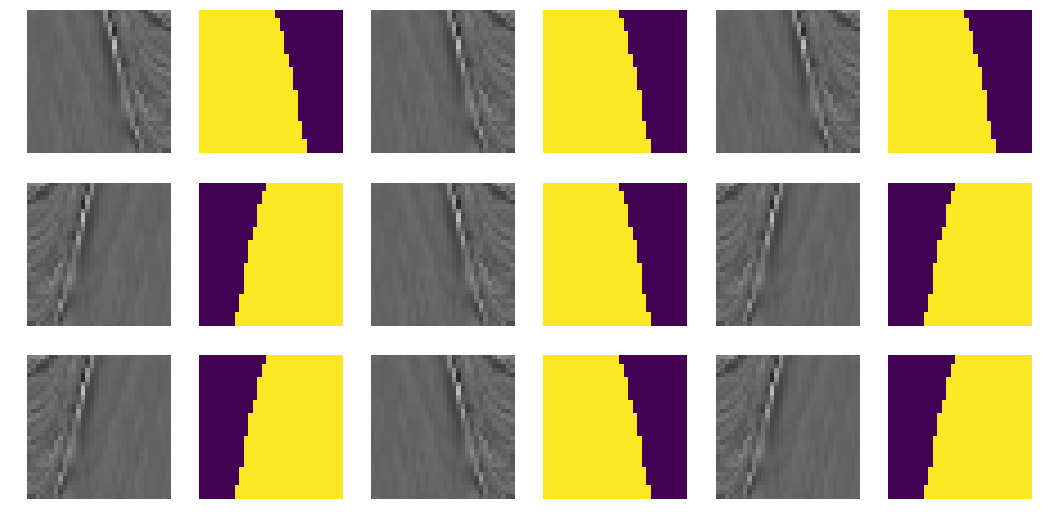

In [22]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))
for i,(x,y) in enumerate(batches):
    show_aug_img(x,1, ax=axes.flat[i*2])
    show_aug_img(y,1, ax=axes.flat[i*2+1], nchannels=1, normed=False)

## Simple upsample

In [23]:
f = resnet34
cut,lr_cut = model_meta[f]

In [24]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [25]:
def dice(pred, targs):
    pred = (pred>0.5).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

## U-net (ish)

In [26]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [27]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [28]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [29]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

## Training loop

In [30]:
def trainModel(uid, models, trn_x, trn_y, val_x,val_y, aug_tfms, lr=2e-2, wd=1e-7, bs=64):
    ##32
    print('Running on 32x32')
    sz = 32
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    denorm = md.trn_ds.denorm
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    
    learn.freeze_to(1)
    lrs = np.array([lr/9,lr/3,lr])
    learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/2, 1, wds=wd, cycle_len=20,use_clr=(20,10), best_save_name='tmp')
    
    ##64
    print('Running on 64x64')
    sz = 64
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1,wds=wd, cycle_len=10,use_clr=(10,10), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    
    ##128
    print('Running on 128x128')
    sz = 128
    tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
    datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
    md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
    
    learn = ConvLearner(md, models)
    learn.opt_fn=optim.Adam
    learn.crit=nn.BCEWithLogitsLoss()
    learn.metrics=[dice, accuracy_thresh(0.5)]
    learn.load('tmp')
    
    learn.freeze_to(1)
    learn.fit(lr/2,1, wds=wd, cycle_len=6,use_clr=(6,4), best_save_name='tmp')
    learn.load('tmp')
    learn.unfreeze()
    learn.bn_freeze(True)
    learn.fit(lrs/5,1, wds=wd,cycle_len=8,use_clr=(20,8), best_save_name='tmp')
    learn.load('tmp')
    learn.fit(lrs/5,5, wds=wd,cycle_len=1,cycle_mult=2, best_save_name='model_'+str(uid))

In [31]:
from sklearn.model_selection import KFold

In [32]:
nSplits = 10

In [42]:
kf = KFold(n_splits=nSplits, shuffle=True)
folds = kf.split(trn_x)
for i, (train, test) in enumerate(folds):
    print('_____________________________')
    print('Running fold', i+1,'/', nSplits)
    m_base = get_base()
    m = to_gpu(Unet34(m_base))
    models = UnetModel(m)
    trainModel(i, models, trn_x[train], trn_y[train], trn_x[test], trn_y[test], aug_tfms)
    print('_____________________________')

_____________________________
Running fold 1 / 10
Running on 32x32


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.352139   0.310781   0.761695   0.889008  
    1      0.287014   0.259363   0.788444   0.898166       
    2      0.2508     0.265345   0.814776   0.899911       
    3      0.227851   0.24027    0.774584   0.903412       
    4      0.213783   0.202366   0.809468   0.913828       
    5      0.191679   0.211621   0.805838   0.913074       
    6      0.171767   0.193717   0.839348   0.922549       
    7      0.153654   0.193403   0.841489   0.925793       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.192995   0.202238   0.824006   0.914682  
    1      0.224602   0.270779   0.74027    0.890918       
    2      0.227296   0.227396   0.795833   0.904166       
    3      0.204453   0.207131   0.824655   0.916675       
    4      0.193049   0.211982   0.821479   0.916534       
    5      0.186616   0.215438   0.842425   0.926465       
    6      0.163875   0.205798   0.852182   0.924762       
    7      0.13922    0.185509   0.85022    0.929089       
    8      0.136638   0.196697   0.8413     0.924625       
    9      0.127645   0.18708    0.863252   0.931281       
    10     0.112914   0.181519   0.869482   0.9362         
    11     0.101692   0.194367   0.871677   0.93696        
    12     0.090225   0.192573   0.87396    0.939258        
    13     0.082693   0.21298    0.859374   0.932434        
    14     0.077486   0.188782   0.857914   0.932791        
    15     0.072114   0.210186   0.872763 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.285677   0.206712   0.781927   0.90568   
    1      0.223642   0.184554   0.836364   0.925391       
    2      0.19301    0.162706   0.863965   0.935352       
    3      0.166317   0.152989   0.861746   0.935348       
    4      0.151862   0.159335   0.880089   0.938309       
    5      0.138533   0.155823   0.884684   0.943012       
    6      0.124996   0.145699   0.894923   0.947615       
    7      0.113813   0.159524   0.876171   0.940295       
    8      0.105556   0.153129   0.892061   0.945743       
    9      0.095219   0.163223   0.880115   0.941442        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.125714   0.16835    0.881468   0.94015   
    1      0.12864    0.145635   0.888645   0.945016       
    2      0.141612   0.201755   0.836679   0.925073       
    3      0.129153   0.173982   0.872859   0.93907        
    4      0.105453   0.159151   0.884676   0.942696       
    5      0.089524   0.150437   0.893066   0.946799        
    6      0.077661   0.158726   0.885763   0.943816        
    7      0.069862   0.159028   0.889909   0.945648        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.207116   0.174186   0.864769   0.934776  
    1      0.190416   0.233549   0.847989   0.928983       
    2      0.178639   0.186348   0.841018   0.926631       
    3      0.15954    0.143351   0.87677    0.941259       
    4      0.141388   0.139958   0.892526   0.945977       
    5      0.13259    0.124855   0.891041   0.947281       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.121377   0.145449   0.882787   0.940521  
    1      0.137358   0.14892    0.879998   0.93956        
    2      0.134256   0.133714   0.880039   0.940891       
    3      0.120901   0.122853   0.89327    0.94628        
    4      0.106726   0.136438   0.882888   0.943348       
    5      0.091125   0.124838   0.900309   0.949697        
    6      0.078227   0.125221   0.895058   0.948082        
    7      0.071334   0.121875   0.891835   0.945936        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.10554    0.145105   0.885452   0.943897  
    1      0.105882   0.125262   0.897003   0.948649       
    2      0.086484   0.13356    0.894573   0.947821        
    3      0.09588    0.153126   0.874211   0.937608        
    4      0.091595   0.128278   0.903679   0.95202         
    5      0.078334   0.116012   0.902848   0.951737        
    6      0.068203   0.118373   0.900219   0.950709        
    7      0.074966   0.156651   0.873814   0.937888        
    8      0.099089   0.166277   0.867642   0.937506        
    9      0.089488   0.131274   0.892246   0.946428        
    10     0.077366   0.135928   0.902518   0.950584        
    11     0.065112   0.130702   0.907403   0.953272        
    12     0.05746    0.128518   0.90209    0.951313        
    13     0.052314   0.126753   0.907828   0.954028        
    14     0.050253   0.127474   0.906937   0.953696        
    15     0.063832   0.151916  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.333116   0.380997   0.698804   0.871893  
    1      0.278114   0.319198   0.702474   0.875897       
    2      0.251848   0.272855   0.778246   0.899081       
    3      0.230681   0.24796    0.745764   0.891531       
    4      0.207121   0.263977   0.77899    0.898682       
    5      0.186113   0.238983   0.806028   0.909366       
    6      0.170878   0.25925    0.779772   0.90351        
    7      0.152845   0.266705   0.786034   0.904489       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.190187   0.297559   0.680354   0.871695  
    1      0.218662   0.30346    0.572332   0.842371       
    2      0.217421   0.225355   0.78287    0.902094       
    3      0.219579   0.275887   0.755098   0.893991       
    4      0.200169   0.243653   0.793643   0.901486       
    5      0.18329    0.269993   0.781304   0.903772       
    6      0.163767   0.260217   0.798621   0.910956       
    7      0.151036   0.213728   0.810228   0.912717       
    8      0.132185   0.25942    0.793936   0.909225       
    9      0.129622   0.270721   0.808294   0.909238       
    10     0.12645    0.282562   0.799741   0.909726       
    11     0.11276    0.339547   0.799343   0.909702       
    12     0.097976   0.235281   0.819964   0.916638        
    13     0.088056   0.234409   0.835544   0.921082        
    14     0.080425   0.266043   0.834306   0.922528        
    15     0.07281    0.24134    0.844263 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.294813   0.230484   0.816921   0.916023  
    1      0.212713   0.205243   0.790524   0.907395       
    2      0.183465   0.193201   0.835108   0.923421       
    3      0.169219   0.195557   0.849119   0.928642       
    4      0.151964   0.19751    0.821899   0.916671       
    5      0.139131   0.196203   0.853085   0.928019       
    6      0.124653   0.230369   0.827189   0.921432       
    7      0.113141   0.195553   0.859636   0.93327        
    8      0.103433   0.211973   0.855437   0.931744       
    9      0.093819   0.226735   0.855952   0.93046         


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.12841    0.182439   0.854146   0.929911  
    1      0.126341   0.325833   0.827167   0.921617       
    2      0.123414   0.246318   0.810451   0.915394       
    3      0.113837   0.206339   0.864441   0.934425       
    4      0.0918     0.19942    0.871505   0.938253        
    5      0.080417   0.209866   0.871544   0.938908        
    6      0.068053   0.217951   0.874324   0.939417        
    7      0.061635   0.215261   0.878448   0.941574        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.215175   0.219659   0.831322   0.919989  
    1      0.185736   0.189649   0.851488   0.92638        
    2      0.171383   0.202296   0.822736   0.919943       
    3      0.154403   0.177883   0.862142   0.933678       
    4      0.142105   0.164394   0.867653   0.936839       
    5      0.127721   0.159218   0.866373   0.937344       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.123894   0.163337   0.869004   0.937115  
    1      0.131197   0.173502   0.861876   0.935285       
    2      0.121867   0.192618   0.848739   0.926804       
    3      0.112517   0.164036   0.85904    0.932847       
    4      0.105363   0.173588   0.8713     0.938638       
    5      0.09179    0.155704   0.880367   0.942331        
    6      0.078142   0.167182   0.88429    0.9451          
    7      0.069347   0.166141   0.886514   0.946017        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.093717   0.166739   0.882262   0.943464  
    1      0.088836   0.210338   0.852747   0.932699        
    2      0.07587    0.189179   0.877881   0.942126        
    3      0.089377   0.175733   0.875897   0.938288        
    4      0.085701   0.173292   0.881691   0.94326         
    5      0.073745   0.177569   0.879072   0.942704        
    6      0.062726   0.18039    0.879405   0.942878        
    7      0.061855   0.173353   0.880865   0.941396        
    8      0.071358   0.184921   0.864783   0.935081        
    9      0.084295   0.177588   0.872461   0.937385        
    10     0.089937   0.168276   0.881137   0.942562        
    11     0.075946   0.17058    0.872463   0.939404        
    12     0.063119   0.175124   0.882183   0.944217        
    13     0.05626    0.17719    0.883333   0.944631        
    14     0.052059   0.177605   0.884251   0.945143        
    15     0.053478   0.181667

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.340367   0.44848    0.667454   0.86871   
    1      0.277552   0.248552   0.739931   0.894189       
    2      0.247103   0.227072   0.806385   0.912534       
    3      0.219094   0.223142   0.824683   0.917221       
    4      0.202541   0.222381   0.82825    0.917816       
    5      0.188247   0.193193   0.841136   0.924396       
    6      0.171092   0.199249   0.827793   0.922861       
    7      0.159458   0.202152   0.850924   0.927277       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.194912   0.265789   0.81936    0.907047  
    1      0.230433   0.265106   0.790085   0.908633       
    2      0.242541   0.230618   0.811622   0.915189       
    3      0.229591   0.238002   0.820671   0.912534       
    4      0.185355   0.173974   0.860971   0.93479        
    5      0.171563   0.211821   0.824942   0.919913       
    6      0.157638   0.176927   0.858277   0.933807       
    7      0.144672   0.20136    0.831448   0.915784       
    8      0.140879   0.19273    0.861023   0.932687       
    9      0.133098   0.213046   0.838075   0.920947       
    10     0.134975   0.207078   0.829853   0.921201       
    11     0.117361   0.186335   0.858712   0.931967       
    12     0.098922   0.173357   0.871708   0.938031        
    13     0.087011   0.156722   0.874972   0.939905        
    14     0.077175   0.164452   0.866167   0.937918        
    15     0.071003   0.158728   0.881367 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.292945   0.209294   0.801692   0.913201  
    1      0.219505   0.168471   0.861082   0.936398       
    2      0.190717   0.187669   0.864146   0.934393       
    3      0.168993   0.158141   0.859618   0.937026       
    4      0.153865   0.157425   0.878291   0.942867       
    5      0.140669   0.160264   0.87907    0.94241        
    6      0.131218   0.156976   0.880152   0.941941       
    7      0.121285   0.143227   0.885206   0.946159       
    8      0.110483   0.141897   0.892084   0.948429       
    9      0.101964   0.153297   0.884562   0.944247       


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.118803   0.161934   0.864712   0.937893  
    1      0.122751   0.184722   0.872658   0.936369       
    2      0.118681   0.168926   0.883033   0.942044       
    3      0.106204   0.147537   0.893451   0.948505       
    4      0.091624   0.143728   0.901588   0.952366        
    5      0.081204   0.15221    0.894824   0.948428        
    6      0.072562   0.148456   0.890969   0.947038        
    7      0.064554   0.134673   0.906656   0.955476        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.194235   0.153448   0.880839   0.945412  
    1      0.178125   0.190185   0.869407   0.93498        
    2      0.165785   0.140598   0.891163   0.949217       
    3      0.148756   0.153414   0.88053    0.942178       
    4      0.139043   0.139251   0.889458   0.948786       
    5      0.124761   0.139315   0.891527   0.948972       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.120902   0.156199   0.873708   0.938699  
    1      0.136762   0.154764   0.883354   0.94319        
    2      0.134663   0.141116   0.891676   0.946889       
    3      0.112513   0.146094   0.882033   0.942331       
    4      0.102735   0.162401   0.874294   0.937118       
    5      0.088164   0.141824   0.895222   0.948354        
    6      0.078133   0.148184   0.893298   0.947768        
    7      0.071535   0.144025   0.895727   0.948943        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.090316   0.131739   0.892743   0.94807   
    1      0.098176   0.145178   0.886442   0.942615        
    2      0.080087   0.138934   0.905939   0.954239        
    3      0.089073   0.128723   0.908029   0.953766        
    4      0.097287   0.122845   0.902646   0.953503        
    5      0.079729   0.138769   0.899291   0.950668        
    6      0.067459   0.135594   0.896738   0.949282        
    7      0.072072   0.211786   0.876589   0.940883        
    8      0.099075   0.19127    0.872983   0.940203        
    9      0.087029   0.158713   0.889529   0.945973        
    10     0.071608   0.178698   0.880053   0.939977        
    11     0.061817   0.152715   0.90658    0.955326        
    12     0.054761   0.155553   0.906765   0.955041        
    13     0.051732   0.155469   0.90541    0.954311        
    14     0.049614   0.157197   0.904407   0.95373         
    15     0.060334   0.178336

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.347929   0.519722   0.46173    0.839874  
    1      0.298145   0.261065   0.716418   0.89462        
    2      0.260687   0.26719    0.679935   0.887198       
    3      0.235313   0.228258   0.78352    0.909085       
    4      0.221939   0.203111   0.766824   0.911203       
    5      0.205551   0.202283   0.796291   0.917767       
    6      0.190848   0.190043   0.816925   0.92421        
    7      0.176323   0.192456   0.804454   0.921579       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.210305   0.19171    0.799399   0.921341  
    1      0.231155   0.227832   0.797031   0.913196       
    2      0.247767   0.211431   0.757038   0.906158       
    3      0.220749   0.190815   0.778709   0.915436       
    4      0.204916   0.20368    0.785544   0.919113       
    5      0.188965   0.181992   0.833032   0.930115       
    6      0.174436   0.196064   0.80391    0.924149       
    7      0.169612   0.213313   0.821224   0.926483       
    8      0.153213   0.198069   0.827832   0.927411       
    9      0.141411   0.170894   0.838157   0.933392       
    10     0.125076   0.175043   0.83824    0.935104       
    11     0.114073   0.170126   0.833299   0.934491       
    12     0.105842   0.178985   0.866813   0.944452       
    13     0.096112   0.163438   0.857485   0.940778        
    14     0.086266   0.167005   0.863152   0.944467        
    15     0.077502   0.173391   0.849048  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.294207   0.198971   0.82826    0.928705  
    1      0.236365   0.169673   0.809121   0.926485       
    2      0.192241   0.161406   0.847196   0.938751       
    3      0.175961   0.154335   0.845148   0.938319       
    4      0.162739   0.145791   0.862876   0.945012       
    5      0.149496   0.140951   0.869063   0.947313       
    6      0.140733   0.135946   0.867234   0.946211       
    7      0.130235   0.135984   0.866695   0.946416       
    8      0.124053   0.130035   0.86862    0.947615       
    9      0.113413   0.130241   0.874133   0.949253       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.125886   0.166575   0.855604   0.941148  
    1      0.138349   0.142761   0.871286   0.947591       
    2      0.125333   0.158628   0.857382   0.94056        
    3      0.113323   0.141979   0.852769   0.942523       
    4      0.102812   0.127929   0.87821    0.95153        
    5      0.092674   0.140775   0.874329   0.950024        
    6      0.081542   0.13054    0.87586    0.950957        
    7      0.073123   0.126034   0.882918   0.953574        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.207723   0.154383   0.834991   0.934536  
    1      0.190367   0.158897   0.847476   0.939119       
    2      0.173667   0.151662   0.866522   0.944972       
    3      0.159327   0.144469   0.863058   0.944623       
    4      0.14801    0.155212   0.854885   0.941491       
    5      0.136905   0.146589   0.857348   0.942765       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.152371   0.155049   0.85217    0.938427  
    1      0.163083   0.149924   0.87275    0.947936       
    2      0.144521   0.136513   0.871508   0.948783       
    3      0.131342   0.147478   0.867987   0.94612        
    4      0.122859   0.130955   0.877249   0.951174       
    5      0.112251   0.151378   0.883001   0.951373       
    6      0.096746   0.142283   0.886213   0.953666        
    7      0.086088   0.134251   0.885965   0.953402        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.119679   0.126999   0.893345   0.95619   
    1      0.114001   0.12983    0.873603   0.949227       
    2      0.097429   0.127583   0.882642   0.952635        
    3      0.105878   0.14138    0.889479   0.954816        
    4      0.10114    0.122607   0.892326   0.956421       
    5      0.084469   0.137571   0.888387   0.954442        
    6      0.071625   0.136167   0.895313   0.957496        
    7      0.095728   0.137352   0.872909   0.947995        
    8      0.108927   0.154607   0.875942   0.9486          
    9      0.09778    0.169331   0.865357   0.94124         
    10     0.092475   0.143212   0.886757   0.954939        
    11     0.074866   0.125116   0.892165   0.955962        
    12     0.064322   0.14485    0.886416   0.955149        
    13     0.056919   0.147888   0.891042   0.956812        
    14     0.054403   0.149994   0.889181   0.956233        
    15     0.06121    0.166188   

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.330264   0.502434   0.488448   0.838846  
    1      0.266465   0.335585   0.659815   0.876392       
    2      0.239801   0.295912   0.657031   0.876932       
    3      0.215187   0.243465   0.745927   0.900272       
    4      0.200579   0.280881   0.780167   0.896649       
    5      0.179808   0.242431   0.785925   0.908539       
    6      0.163221   0.246138   0.772553   0.906454       
    7      0.148282   0.238036   0.787105   0.909689       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.187815   0.28575    0.689358   0.881924  
    1      0.329857   0.346053   0.640873   0.860928       
    2      0.295584   0.307828   0.720779   0.889041       
    3      0.264442   0.22599    0.790698   0.912521       
    4      0.229541   0.247156   0.743409   0.899646       
    5      0.209597   0.224345   0.782699   0.908475       
    6      0.188998   0.265372   0.775586   0.901187       
    7      0.181394   0.217423   0.80891    0.915988       
    8      0.161669   0.209254   0.809227   0.916663       
    9      0.144659   0.248148   0.811761   0.912311       
    10     0.137248   0.220139   0.803786   0.914331       
    11     0.11869    0.243824   0.815065   0.911328       
    12     0.107983   0.215203   0.803385   0.91709        
    13     0.097627   0.231541   0.826962   0.922745        
    14     0.08741    0.272667   0.799693   0.911508        
    15     0.0839     0.24767    0.818162  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.281022   0.243278   0.752432   0.903662  
    1      0.214569   0.202838   0.819253   0.922665       
    2      0.184263   0.186534   0.841768   0.929871       
    3      0.164102   0.173534   0.847549   0.932243       
    4      0.147538   0.182493   0.838251   0.929829       
    5      0.137794   0.184204   0.856114   0.934896       
    6      0.128521   0.173416   0.86337    0.938625       
    7      0.119413   0.168281   0.859974   0.93731        
    8      0.115952   0.168395   0.871099   0.940591       
    9      0.102453   0.170525   0.867097   0.939008       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.123247   0.190521   0.812525   0.922588  
    1      0.135851   0.187352   0.844941   0.931177       
    2      0.123394   0.172128   0.859854   0.937634       
    3      0.108546   0.177655   0.871311   0.942934       
    4      0.102362   0.188047   0.844792   0.932227        
    5      0.090973   0.174136   0.868585   0.940963        
    6      0.07824    0.155265   0.877821   0.944777        
    7      0.06956    0.170188   0.872279   0.942621        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.213302   0.211105   0.800839   0.917877  
    1      0.200094   0.225166   0.79667    0.916981       
    2      0.181254   0.186909   0.815587   0.923065       
    3      0.163491   0.166576   0.848627   0.93351        
    4      0.150976   0.169366   0.858793   0.935378       
    5      0.1367     0.159671   0.858662   0.937026       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.141385   0.160511   0.868052   0.940737  
    1      0.139784   0.182799   0.811586   0.920602       
    2      0.136233   0.150188   0.873012   0.943129       
    3      0.123246   0.181455   0.864637   0.93471        
    4      0.109213   0.145564   0.878006   0.944119       
    5      0.09503    0.149529   0.882669   0.945175        
    6      0.083804   0.153301   0.865522   0.939174        
    7      0.075532   0.149048   0.880628   0.944885        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.1046     0.143188   0.879219   0.944471  
    1      0.102722   0.152439   0.877539   0.944097        
    2      0.088776   0.131005   0.889403   0.950675        
    3      0.10074    0.22013    0.835148   0.916313        
    4      0.110513   0.155792   0.864082   0.940419       
    5      0.094112   0.147365   0.872755   0.942344        
    6      0.079928   0.13826    0.879727   0.946048        
    7      0.082646   0.163025   0.866958   0.941222        
    8      0.087302   0.153303   0.880741   0.944757        
    9      0.080809   0.14593    0.869759   0.941562        
    10     0.070749   0.151129   0.883419   0.947509        
    11     0.062564   0.143926   0.890709   0.950039        
    12     0.057105   0.144949   0.895213   0.95307         
    13     0.053045   0.151256   0.895648   0.953432        
    14     0.050367   0.150597   0.896244   0.953661        
    15     0.053784   0.152498 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.36194    4.966119   0.587375   0.796494  
    1      0.291146   0.242141   0.778947   0.907593       
    2      0.252087   0.219917   0.794993   0.916434       
    3      0.225459   0.219557   0.802762   0.918536       
    4      0.207736   0.209393   0.765815   0.915652       
    5      0.192059   0.207321   0.825204   0.924866       
    6      0.173362   0.19509    0.817203   0.924643       
    7      0.15129    0.188049   0.824838   0.928839       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.197178   0.29079    0.772156   0.895413  
    1      0.224198   0.256567   0.789411   0.912775       
    2      0.241773   0.211294   0.792816   0.922925       
    3      0.221647   0.234304   0.644608   0.885876       
    4      0.209901   0.198821   0.812603   0.929001       
    5      0.185712   0.184356   0.834651   0.932526       
    6      0.165697   0.20131    0.845967   0.934485       
    7      0.156448   0.186613   0.831166   0.933185       
    8      0.147409   0.180061   0.859093   0.939841       
    9      0.136359   0.204894   0.817464   0.924481       
    10     0.121724   0.176778   0.85529    0.939542       
    11     0.108952   0.180148   0.854335   0.941699       
    12     0.095094   0.182749   0.849626   0.941113        
    13     0.085145   0.199818   0.858555   0.941733        
    14     0.078615   0.19629    0.861972   0.943723        
    15     0.076938   0.166333   0.874658 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.277405   0.17824    0.80615    0.927952  
    1      0.210238   0.162551   0.828863   0.93535        
    2      0.179814   0.151453   0.846898   0.938944       
    3      0.164738   0.150313   0.86534    0.946391       
    4      0.149756   0.17317    0.852151   0.937306       
    5      0.142123   0.148575   0.863517   0.943814       
    6      0.132806   0.166366   0.873181   0.943563       
    7      0.118703   0.145363   0.872253   0.946558       
    8      0.107307   0.156333   0.874008   0.945464       
    9      0.09465    0.162823   0.877204   0.945744        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.108119   0.186314   0.847408   0.9357    
    1      0.125697   0.177513   0.85231    0.941219       
    2      0.126063   0.161687   0.862515   0.940811       
    3      0.108346   0.191826   0.823772   0.924422       
    4      0.094027   0.174428   0.858429   0.942809        
    5      0.083241   0.202816   0.851082   0.935146        
    6      0.073924   0.16546    0.866506   0.943154        
    7      0.064838   0.170819   0.861441   0.94253         
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.210827   0.191469   0.802102   0.925707  
    1      0.192168   0.156812   0.8399     0.939293       
    2      0.169329   0.15922    0.866867   0.947589       
    3      0.1634     0.155757   0.861968   0.944374       
    4      0.155771   0.155352   0.863901   0.945909       
    5      0.137578   0.149908   0.868036   0.947253       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.128214   0.168618   0.847504   0.941902  
    1      0.131392   0.160181   0.863163   0.94478        
    2      0.124961   0.195321   0.853036   0.938379       
    3      0.115785   0.164244   0.857218   0.942882       
    4      0.103505   0.14729    0.871519   0.945317       
    5      0.089695   0.146161   0.874484   0.945939        
    6      0.076991   0.161476   0.860399   0.941462        
    7      0.068959   0.15784    0.862536   0.942648        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.097329   0.142541   0.876091   0.947954  
    1      0.096614   0.156775   0.878243   0.950432        
    2      0.083532   0.143643   0.886017   0.951139        
    3      0.083539   0.179269   0.867556   0.942414        
    4      0.083289   0.164484   0.869054   0.946459        
    5      0.070779   0.181142   0.867098   0.943852        
    6      0.061849   0.173169   0.873472   0.946929        
    7      0.076915   0.187075   0.808435   0.927538        
    8      0.120185   0.201166   0.841749   0.936713        
    9      0.125951   0.150068   0.872267   0.947662       
    10     0.097279   0.148437   0.879546   0.949633        
    11     0.078301   0.181972   0.865317   0.944729        
    12     0.064895   0.169697   0.875003   0.949206        
    13     0.058836   0.171446   0.869127   0.945511        
    14     0.053893   0.171452   0.870877   0.946586        
    15     0.088784   0.29759  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.3373     0.370058   0.551214   0.846207  
    1      0.275136   0.260023   0.748349   0.892752       
    2      0.248314   0.23007    0.779162   0.907242       
    3      0.226835   0.21176    0.794527   0.911151       
    4      0.212074   0.227184   0.748984   0.898645       
    5      0.194255   0.221499   0.779911   0.907773       
    6      0.174276   0.23438    0.789576   0.908542       
    7      0.164141   0.216115   0.811774   0.916519       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.185222   0.261212   0.799506   0.906924  
    1      0.231573   0.291309   0.704597   0.884717       
    2      0.22839    0.288865   0.754612   0.889801       
    3      0.209966   0.226298   0.79424    0.909326       
    4      0.206059   0.213595   0.818819   0.917715       
    5      0.185185   0.217964   0.782971   0.907104       
    6      0.159234   0.198261   0.82776    0.921555       
    7      0.14151    0.198599   0.835164   0.924301       
    8      0.13768    0.234844   0.831735   0.921429       
    9      0.132367   0.232466   0.814946   0.917706       
    10     0.118967   0.221555   0.82226    0.921619       
    11     0.111718   0.228002   0.83314    0.924435       
    12     0.103366   0.248151   0.810854   0.912531       
    13     0.096396   0.245248   0.807924   0.916058        
    14     0.083805   0.231568   0.838922   0.924207        
    15     0.07438    0.258221   0.834414  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.275573   0.246144   0.773814   0.905894  
    1      0.22062    0.196571   0.825614   0.9212         
    2      0.188961   0.192376   0.838772   0.925566       
    3      0.169087   0.168777   0.837812   0.927252       
    4      0.150224   0.17726    0.861593   0.935212       
    5      0.1374     0.188385   0.836277   0.926318       
    6      0.125273   0.180458   0.853898   0.931686       
    7      0.117517   0.188537   0.858561   0.934135       
    8      0.109649   0.206528   0.859989   0.933728       
    9      0.098922   0.199513   0.855201   0.932253        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.136967   0.200405   0.847353   0.927455  
    1      0.154248   0.217326   0.817655   0.916611       
    2      0.137132   0.234434   0.84137    0.922541       
    3      0.120646   0.191647   0.851726   0.9286         
    4      0.106038   0.198347   0.865121   0.935989       
    5      0.091009   0.192261   0.860591   0.935779        
    6      0.077693   0.201471   0.860787   0.935525        
    7      0.071603   0.206472   0.8618     0.936092        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.208917   0.219074   0.763682   0.903441  
    1      0.195661   0.186011   0.812129   0.920238       
    2      0.176843   0.190631   0.837815   0.924735       
    3      0.164977   0.174649   0.848103   0.930462       
    4      0.15044    0.180972   0.825904   0.922452       
    5      0.136477   0.163936   0.861521   0.936189       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.135293   0.178474   0.833207   0.92693   
    1      0.137529   0.193076   0.857231   0.930568       
    2      0.128105   0.167879   0.861411   0.936767       
    3      0.114086   0.173585   0.863682   0.938267       
    4      0.104955   0.162747   0.872949   0.94027        
    5      0.096801   0.170355   0.859337   0.935401        
    6      0.086274   0.153792   0.87215    0.939928        
    7      0.074476   0.168128   0.869066   0.936687        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.114113   0.174393   0.868783   0.937294  
    1      0.102745   0.179798   0.853633   0.932861        
    2      0.088929   0.186562   0.86066    0.935816        
    3      0.096454   0.155832   0.869709   0.939837        
    4      0.095012   0.159368   0.867096   0.939483        
    5      0.083241   0.186099   0.864189   0.935487        
    6      0.070571   0.184216   0.864181   0.936515        
    7      0.086845   0.178187   0.851651   0.932781        
    8      0.089672   0.193774   0.851212   0.933616        
    9      0.096323   0.175242   0.859766   0.932859        
    10     0.083426   0.175013   0.876643   0.942096        
    11     0.075397   0.190328   0.848422   0.931466        
    12     0.063912   0.174149   0.875512   0.939765        
    13     0.057381   0.17501    0.871692   0.93926         
    14     0.053597   0.174588   0.870072   0.938199        
    15     0.058013   0.181356 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.339783   0.371443   0.625997   0.853894  
    1      0.287134   0.392967   0.739241   0.856195       
    2      0.253355   0.266056   0.77378    0.893234       
    3      0.231493   0.228221   0.766768   0.896744       
    4      0.207745   0.28059    0.731361   0.886447       
    5      0.193397   0.213621   0.806766   0.909372       
    6      0.180531   0.213896   0.827634   0.915915       
    7      0.159416   0.223481   0.817248   0.91492        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.189622   0.264691   0.763412   0.895264  
    1      0.219924   0.251565   0.760312   0.893933       
    2      0.214778   0.283311   0.653603   0.86127        
    3      0.203364   0.232668   0.814962   0.911032       
    4      0.184669   0.232927   0.814624   0.911865       
    5      0.177478   0.239351   0.769743   0.898334       
    6      0.158185   0.219424   0.830136   0.916846       
    7      0.143835   0.184803   0.846413   0.924954       
    8      0.133742   0.196214   0.827523   0.917615       
    9      0.128185   0.255493   0.815988   0.914093       
    10     0.121902   0.234667   0.836663   0.919409       
    11     0.116014   0.196656   0.846051   0.923578       
    12     0.100326   0.217356   0.848522   0.923679       
    13     0.089539   0.212888   0.855815   0.929242        
    14     0.082165   0.194869   0.856781   0.930112        
    15     0.074048   0.213013   0.858194  

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.293386   0.22508    0.786297   0.902848  
    1      0.216713   0.211636   0.79787    0.907665       
    2      0.18822    0.179653   0.855989   0.929734       
    3      0.173631   0.18068    0.844431   0.927032       
    4      0.156235   0.191466   0.851206   0.929488       
    5      0.142029   0.177174   0.855504   0.9309         
    6      0.13129    0.16757    0.874727   0.938517       
    7      0.120226   0.159164   0.889958   0.943607       
    8      0.110188   0.169055   0.890882   0.945181       
    9      0.100727   0.170901   0.885932   0.943297        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.121842   0.177473   0.845951   0.927988  
    1      0.124694   0.171654   0.87325    0.938673       
    2      0.112848   0.174976   0.888535   0.944049       
    3      0.107762   0.144846   0.881998   0.941664       
    4      0.100125   0.161543   0.884148   0.941367        
    5      0.085087   0.137519   0.905652   0.950349        
    6      0.073548   0.171739   0.893997   0.947461        
    7      0.064423   0.154248   0.900822   0.949498        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.192543   0.198596   0.83223    0.920781  
    1      0.187484   0.185207   0.844341   0.926099       
    2      0.17384    0.163778   0.856106   0.930834       
    3      0.156284   0.149778   0.871849   0.937235       
    4      0.142755   0.162477   0.88015    0.939657       
    5      0.128008   0.148187   0.885817   0.943691       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.129789   0.163795   0.876822   0.938954  
    1      0.140426   0.139101   0.87807    0.941216       
    2      0.124213   0.186162   0.873857   0.938258       
    3      0.109284   0.141309   0.890595   0.945911       
    4      0.100491   0.144379   0.884494   0.944279       
    5      0.0868     0.159809   0.890523   0.946274        
    6      0.079225   0.138206   0.899793   0.950658        
    7      0.070026   0.146633   0.898957   0.949972        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.089067   0.161852   0.892826   0.946949  
    1      0.098853   0.141481   0.891497   0.947205        
    2      0.086075   0.149906   0.890646   0.947222        
    3      0.097805   0.158419   0.875348   0.940219        
    4      0.087334   0.170828   0.891071   0.945182        
    5      0.072698   0.157693   0.899453   0.950097        
    6      0.061848   0.160852   0.900674   0.950451        
    7      0.075533   0.1185     0.898948   0.950599        
    8      0.107209   0.185369   0.852439   0.929446        
    9      0.106073   0.14126    0.883321   0.941407       
    10     0.083919   0.143078   0.905298   0.952542        
    11     0.071875   0.139187   0.90441    0.952337        
    12     0.0615     0.139508   0.909101   0.95445         
    13     0.055245   0.142269   0.905578   0.953483        
    14     0.051951   0.1422     0.906148   0.953704        
    15     0.052781   0.154996 

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.349859   0.325953   0.697565   0.879828  
    1      0.295557   0.360813   0.712346   0.871756       
    2      0.256574   0.247569   0.799794   0.910583       
    3      0.234098   0.23169    0.796766   0.911221       
    4      0.213853   0.23858    0.773811   0.903619       
    5      0.193726   0.248481   0.797967   0.905844       
    6      0.172054   0.219602   0.804048   0.913034       
    7      0.154516   0.229529   0.799754   0.911316       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.203777   0.271596   0.7673     0.896112  
    1      0.203716   0.237705   0.776211   0.907385       
    2      0.210613   0.256846   0.760434   0.900247       
    3      0.207293   0.244733   0.790814   0.911298       
    4      0.187267   0.248169   0.765234   0.904953       
    5      0.172313   0.267477   0.777511   0.906461       
    6      0.1581     0.22188    0.808305   0.916879       
    7      0.14884    0.242762   0.788545   0.908905       
    8      0.136109   0.240477   0.788294   0.912747       
    9      0.116525   0.244339   0.812252   0.915207       
    10     0.101461   0.239348   0.821486   0.920352       
    11     0.090799   0.270158   0.819379   0.915872        
    12     0.085462   0.258638   0.808865   0.915207        
    13     0.083769   0.249455   0.817647   0.917117        
    14     0.076765   0.257985   0.825446   0.920563        
    15     0.068984   0.281099   0.816281

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.281721   0.222211   0.787189   0.909817  
    1      0.218691   0.205882   0.824348   0.922149       
    2      0.185622   0.195769   0.834055   0.924447       
    3      0.160498   0.21581    0.821636   0.923466       
    4      0.145764   0.188511   0.818146   0.923271       
    5      0.137889   0.216629   0.841677   0.923193       
    6      0.126994   0.186962   0.847597   0.931114       
    7      0.112734   0.189241   0.846452   0.931967       
    8      0.10011    0.203096   0.848019   0.92953        
    9      0.090172   0.201168   0.857651   0.93614         


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.118017   0.188148   0.852533   0.931254  
    1      0.135078   0.193635   0.847188   0.931161       
    2      0.124534   0.213812   0.850108   0.932367       
    3      0.109577   0.235773   0.826186   0.924682       
    4      0.091793   0.219688   0.855872   0.933775        
    5      0.075519   0.223492   0.852072   0.9315          
    6      0.067844   0.212376   0.854015   0.932098        
    7      0.060776   0.222382   0.859283   0.935246        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.195629   0.218454   0.818279   0.916584  
    1      0.184335   0.183212   0.848379   0.932          
    2      0.162988   0.196512   0.836412   0.925342       
    3      0.146399   0.177673   0.845378   0.930862       
    4      0.133337   0.189056   0.847804   0.932478       
    5      0.119553   0.20327    0.84044    0.924967       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.157321   0.177409   0.842754   0.929408  
    1      0.149784   0.184602   0.835766   0.926238       
    2      0.140285   0.169171   0.869522   0.940707       
    3      0.125845   0.183129   0.862242   0.935912       
    4      0.114781   0.181259   0.853112   0.933563       
    5      0.101735   0.16465    0.868129   0.940233       
    6      0.086842   0.177473   0.861892   0.937131        
    7      0.077389   0.181155   0.863313   0.938602        


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.123906   0.165757   0.863509   0.937768  
    1      0.121278   0.160844   0.873096   0.941831       
    2      0.10331    0.166206   0.861771   0.937236       
    3      0.124547   0.227604   0.817793   0.918654       
    4      0.122574   0.178978   0.866681   0.940459       
    5      0.104178   0.174489   0.866246   0.938248       
    6      0.086866   0.176561   0.864342   0.938326        
    7      0.108859   0.168044   0.862166   0.937016        
    8      0.104575   0.18173    0.851769   0.932829       
    9      0.095096   0.204089   0.839521   0.928511        
    10     0.083378   0.190302   0.870841   0.939757        
    11     0.071633   0.176942   0.872264   0.941122        
    12     0.061833   0.193723   0.871385   0.941088        
    13     0.05639    0.183402   0.875725   0.942885        
    14     0.053535   0.184494   0.875588   0.942794        
    15     0.080496   0.168432   0.85

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.323349   0.345083   0.776774   0.895749  
    1      0.277897   0.344111   0.776044   0.881796       
    2      0.248275   0.281775   0.819481   0.909705       
    3      0.222752   0.22436    0.829927   0.922974       
    4      0.204514   0.206821   0.841528   0.928726       
    5      0.190755   0.223632   0.827718   0.920285       
    6      0.1745     0.218606   0.84239    0.926871       
    7      0.158719   0.203953   0.843427   0.929898       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.197489   0.220295   0.805414   0.917529  
    1      0.218447   0.323377   0.582278   0.852396       
    2      0.249164   0.258337   0.754208   0.899048       
    3      0.226741   0.204203   0.832259   0.924539       
    4      0.1971     0.207942   0.845978   0.92785        
    5      0.179689   0.21367    0.833798   0.924246       
    6      0.163851   0.220206   0.836095   0.926657       
    7      0.163078   0.219425   0.813681   0.918842       
    8      0.141074   0.211457   0.852633   0.931915       
    9      0.119774   0.231492   0.84562    0.926831       
    10     0.129101   0.241287   0.824979   0.915564       
    11     0.12437    0.25623    0.812617   0.91756        
    12     0.119774   0.204116   0.847529   0.93187        
    13     0.104476   0.236699   0.846766   0.928061       
    14     0.090364   0.229173   0.850767   0.933533        
    15     0.081262   0.23944    0.857014   

epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.269395   0.221656   0.789466   0.908231  
    1      0.209678   0.205789   0.826995   0.923531       
    2      0.191558   0.190421   0.844426   0.930621       
    3      0.177054   0.203946   0.836679   0.923941       
    4      0.157565   0.204837   0.844845   0.928118       
    5      0.146972   0.184864   0.844546   0.930635       
    6      0.132351   0.185318   0.851983   0.935136       
    7      0.122109   0.189178   0.842185   0.931175       
    8      0.111884   0.202641   0.858281   0.933965       
    9      0.102696   0.208877   0.855422   0.935162       


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.129801   0.214773   0.810795   0.918486  
    1      0.13114    0.212739   0.829393   0.923864       
    2      0.117762   0.207923   0.849599   0.934304       
    3      0.104265   0.178365   0.875507   0.942921       
    4      0.090305   0.182195   0.87234    0.940188        
    5      0.081244   0.221156   0.855554   0.934892        
    6      0.072053   0.182698   0.874676   0.94329         
    7      0.064224   0.195585   0.8732     0.942382        
Running on 128x128


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.200585   0.203012   0.853455   0.93143   
    1      0.185272   0.20605    0.766503   0.906752       
    2      0.173157   0.16239    0.866644   0.940984       
    3      0.158941   0.169861   0.878562   0.942832       
    4      0.144479   0.157497   0.867704   0.941636       
    5      0.132424   0.154778   0.877518   0.945126       


epoch      trn_loss   val_loss   dice       <lambda>       
    0      0.143131   0.167311   0.868194   0.939413  
    1      0.140372   0.176464   0.85898    0.936988       
    2      0.134395   0.150194   0.881922   0.946908       
    3      0.11896    0.168956   0.85886    0.936561       
    4      0.107015   0.183561   0.871606   0.939065       
    5      0.093709   0.152062   0.888867   0.948771        
    6      0.082316   0.169798   0.887817   0.948617        
    7      0.07426    0.151531   0.898452   0.953376        


epoch      trn_loss   val_loss   dice       <lambda>        
    0      0.09831    0.145967   0.889502   0.948729  
    1      0.097559   0.135342   0.896313   0.953021        
    2      0.080422   0.150428   0.895453   0.952751        
    3      0.082413   0.156413   0.883735   0.947677        
    4      0.083364   0.17135    0.885307   0.947946        
    5      0.073131   0.161622   0.896093   0.952393        
    6      0.06364    0.161509   0.897126   0.952944        
    7      0.075049   0.234369   0.836751   0.92679         
    8      0.091537   0.174387   0.885066   0.947016        
    9      0.094695   0.178566   0.874733   0.942602        
    10     0.082837   0.184667   0.878355   0.940497        
    11     0.067469   0.157045   0.900827   0.95428         
    12     0.058265   0.161319   0.905999   0.957068        
    13     0.052942   0.161666   0.906765   0.957239        
    14     0.050434   0.161833   0.906723   0.957247        
    15     0.067773   0.15511 

In [33]:
def predict(md, nSplits, models, shape, test=False):
    probs = np.zeros(shape)
    for i in range(nSplits):
        learn = ConvLearner(md, models)
        learn.load('model_'+str(i))
        probs += learn.predict(is_test=test)
    _, y = learn.TTA(n_aug=1, is_test=test)
    return probs/nSplits, y 

# Test on original validation

In [34]:
sz=128
bs=64

In [35]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [36]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [37]:
probs, y = predict(md, nSplits, models, (len(val_y), sz, sz))

In [38]:
y.shape, probs.shape

((800, 128, 128), (800, 128, 128))

In [39]:
idx=0

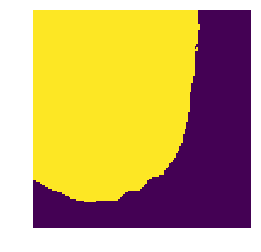

In [40]:
show_img(probs[idx]>0.5);

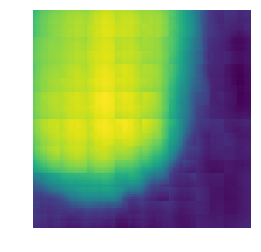

In [41]:
show_img(probs[idx]);

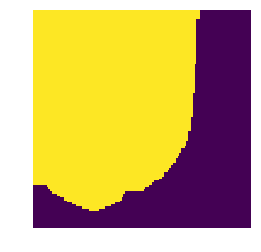

In [42]:
show_img(y[idx]);

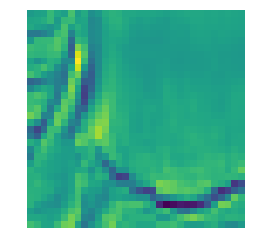

In [43]:
show_img(x[idx][0]);

# Optimise threshold

In [44]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])
resizeY = np.array([resize_img(x) for x in y])

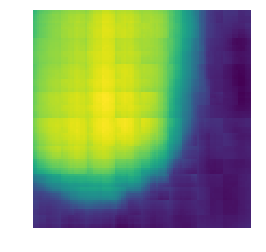

In [45]:
show_img(resizePreds[idx]);

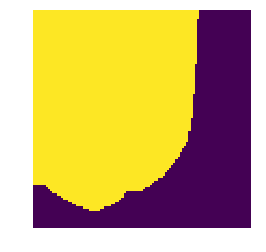

In [46]:
show_img(resizeY[idx]);

In [47]:
# src: https://www.kaggle.com/aglotero/another-iou-metric
def iou_metric(y_true_in, y_pred_in, print_table=False):
    labels = y_true_in
    y_pred = y_pred_in
    
    true_objects = 2
    pred_objects = 2

    intersection = np.histogram2d(labels.flatten(), y_pred.flatten(), bins=(true_objects, pred_objects))[0]

    # Compute areas (needed for finding the union between all objects)
    area_true = np.histogram(labels, bins = true_objects)[0]
    area_pred = np.histogram(y_pred, bins = pred_objects)[0]
    area_true = np.expand_dims(area_true, -1)
    area_pred = np.expand_dims(area_pred, 0)

    # Compute union
    union = area_true + area_pred - intersection

    # Exclude background from the analysis
    intersection = intersection[1:,1:]
    union = union[1:,1:]
    union[union == 0] = 1e-9

    # Compute the intersection over union
    iou = intersection / union

    # Precision helper function
    def precision_at(threshold, iou):
        matches = iou > threshold
        true_positives = np.sum(matches, axis=1) == 1   # Correct objects
        false_positives = np.sum(matches, axis=0) == 0  # Missed objects
        false_negatives = np.sum(matches, axis=1) == 0  # Extra objects
        tp, fp, fn = np.sum(true_positives), np.sum(false_positives), np.sum(false_negatives)
        return tp, fp, fn

    # Loop over IoU thresholds
    prec = []
    if print_table:
        print("Thresh\tTP\tFP\tFN\tPrec.")
    for t in np.arange(0.5, 1.0, 0.05):
        tp, fp, fn = precision_at(t, iou)
        if (tp + fp + fn) > 0:
            p = tp / (tp + fp + fn)
        else:
            p = 0
        if print_table:
            print("{:1.3f}\t{}\t{}\t{}\t{:1.3f}".format(t, tp, fp, fn, p))
        prec.append(p)
    
    if print_table:
        print("AP\t-\t-\t-\t{:1.3f}".format(np.mean(prec)))
    return np.mean(prec)

def iou_metric_batch(y_true_in, y_pred_in):
    batch_size = y_true_in.shape[0]
    metric = []
    for batch in range(batch_size):
        value = iou_metric(y_true_in[batch], y_pred_in[batch])
        metric.append(value)
    return np.mean(metric)

In [73]:
thres = np.linspace(-1, 1, 10)
thres_ioc = [iou_metric_batch(resizeY, np.int32(resizePreds > t)) for t in tqdm_notebook(thres)]

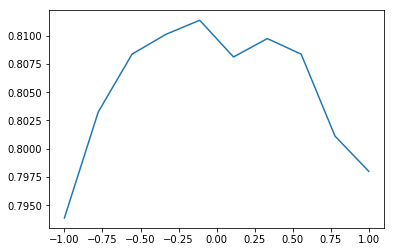

In [74]:
plt.plot(thres, thres_ioc);

In [75]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(-0.11111111111111116, 0.8113749999999998)

In [76]:
thres = np.linspace(-0.75, 0.25, 50)
thres_ioc = [iou_metric_batch(resizeY, np.int32(resizePreds > t)) for t in tqdm_notebook(thres)]

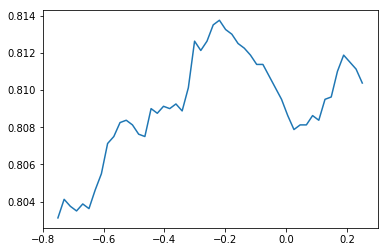

In [77]:
plt.plot(thres, thres_ioc);

In [78]:
best_thres = thres[np.argmax(thres_ioc)]
best_thres, max(thres_ioc)

(-0.2193877551020409, 0.81375)

In [79]:
best_thres=-0.2193877551020409

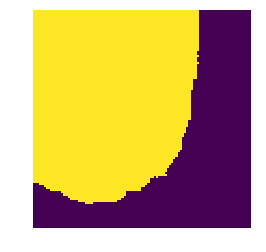

In [80]:
show_img(resizePreds[0]>best_thres);

# Run on test

In [81]:
sz=128
bs=64

In [82]:
(PATH/'test-128').mkdir(exist_ok=True)

In [83]:
def resize_img(fn):
    Image.open(fn).resize((128,128)).save((fn.parent.parent)/'test-128'/fn.name)

files = list((PATH/'test').iterdir())
with ThreadPoolExecutor(8) as e: e.map(resize_img, files)

In [84]:
testData = np.array(glob(f'{PATH}/test-128/*'))

In [85]:
class TestFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.fnames[i]))
    def get_c(self): return 0

In [86]:
tfms=tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(TestFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, test=testData, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [87]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [88]:
learn = ConvLearner(md, models)

In [89]:
learn.load('model_4')

In [90]:
x,y = next(iter(md.test_dl))
py = to_np(learn.model(V(x)))

In [91]:
x.shape

torch.Size([64, 3, 128, 128])

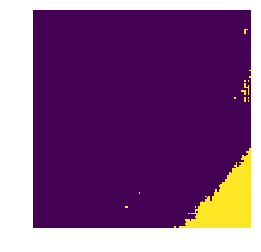

In [92]:
show_img(py[6]>best_thres);

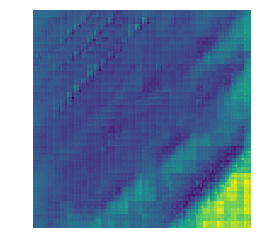

In [93]:
show_img(py[6]);

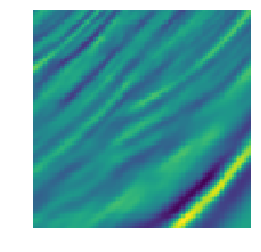

In [94]:
show_img(y[6]);

In [95]:
py.shape

(64, 128, 128)

In [97]:
probs, y = predict(md, nSplits, models, (len(testData), sz, sz), test=True)

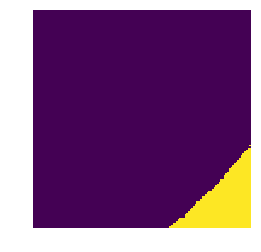

In [101]:
show_img(probs[6]>best_thres);

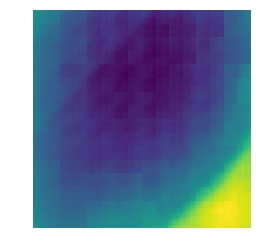

In [102]:
show_img(probs[6]);

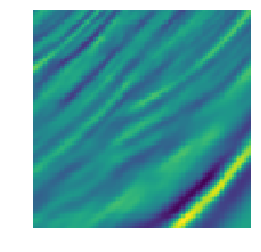

In [103]:
show_img(y[6]);

In [104]:
def resize_img(fn):
    return np.array(Image.fromarray(fn).resize((101,101)))

resizePreds = np.array([resize_img(x) for x in probs])

In [105]:
resizePreds.shape

(18000, 101, 101)

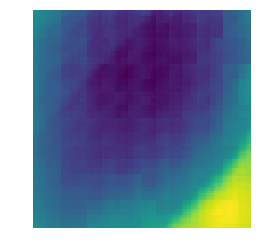

In [106]:
show_img(resizePreds[6]);

In [107]:
testData

array(['/home/giles/Downloads/fastai_data/salt/test-128/ac26efe98e.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/0a5eac8775.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/bdb1c1fcbf.png', ...,
       '/home/giles/Downloads/fastai_data/salt/test-128/3bceaa0303.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/96867a3897.png',
       '/home/giles/Downloads/fastai_data/salt/test-128/52f6267e3f.png'], dtype='<U62')

In [108]:
f'{PATH}/test'

'/home/giles/Downloads/fastai_data/salt/test'

In [109]:
test_ids = next(os.walk(f'{PATH}/test'))[2]

In [110]:
def RLenc(img, order='F', format=True):
    """
    img is binary mask image, shape (r,c)
    order is down-then-right, i.e. Fortran
    format determines if the order needs to be preformatted (according to submission rules) or not

    returns run length as an array or string (if format is True)
    """
    bytes = img.reshape(img.shape[0] * img.shape[1], order=order)
    runs = []  ## list of run lengths
    r = 0  ## the current run length
    pos = 1  ## count starts from 1 per WK
    for c in bytes:
        if (c == 0):
            if r != 0:
                runs.append((pos, r))
                pos += r
                r = 0
            pos += 1
        else:
            r += 1

    # if last run is unsaved (i.e. data ends with 1)
    if r != 0:
        runs.append((pos, r))
        pos += r
        r = 0

    if format:
        z = ''

        for rr in runs:
            z += '{} {} '.format(rr[0], rr[1])
        return z[:-1]
    else:
        return runs

In [111]:
pred_dict = {id_[:-4]:RLenc(np.round(resizePreds[i] > best_thres)) for i,id_ in tqdm_notebook(enumerate(test_ids))}

In [112]:
sub = pd.DataFrame.from_dict(pred_dict,orient='index')
sub.index.names = ['id']
sub.columns = ['rle_mask']
sub.to_csv('submission.csv')

In [113]:
sub

,rle_mask
id,
ac26efe98e,1 43 102 43 203 43 304 42 405 42 506 41 607 39...
0a5eac8775,
bdb1c1fcbf,
5358961921,
b7b72a69d1,
c1169d47ce,
89eb8ef89f,6464 1 6564 2 6665 2 6765 3 6865 4 6965 5 7066...
696d91b37e,
73053e4d03,1 2 102 2 203 3 207 2 304 6 405 7 506 10 607 1...
